In [110]:

import sys, os, glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from music21 import *
from midi2audio import FluidSynth
from IPython.display import Audio

from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils



In [111]:
class MIDI():
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.file_notes = []
        self.trainseq = []
        self.transfer_dic = dict()
        self.dic_n = 0

    def parser(self, folderName):
        """ Get all the rests and notes and chords from the midi files """

        for file in glob.glob(f"{folderName}/*.mid"):
            midi = converter.parse(file)
            print("Parsing %s" % file)

            notes = []
            for element in midi.flat.elements:
                if isinstance(element, note.Rest) and element.offset != 0:
                    notes.append('R')
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                if isinstance(element, chord.Chord):
                    notes.append('.'.join(str(pitch) for pitch in element.pitches))

            self.file_notes.append(notes)
        note_set = sorted(set(note for notes in self.file_notes for note in notes))
        self.dic_n = len(note_set)
        # A dictionary to map notes, chords and rest to integers
        self.transfer_dic = dict((note, number) for number, note in enumerate(note_set))

    def prepare_sequences(self):
        """ Prepare the sequences used by the Neural Network """

        # create input sequences and the corresponding outputs
        for notes in self.file_notes:
            for i in range(len(notes) - self.seq_length):
                self.trainseq.append([self.transfer_dic[note] for note in notes[i:i + self.seq_length]])

        # Normalize sequences between -1 and 1
        self.trainseq = np.array(self.trainseq)
        self.trainseq = (self.trainseq - float(self.dic_n) / 2) / (float(self.dic_n) / 2)

        return self.trainseq

    def create_midi(self, prediction_output, filename):
        """ convert the output from the prediction to notes and create a midi file
        from the notes """
        offset = 0
        midi_stream = stream.Stream()

        # create note and chord objects based on the values generated by the model
        for pattern in prediction_output:
            # rest
            if pattern == 'R':
                midi_stream.append(note.Rest())
            # chord
            elif ('.' in pattern) or pattern.isdigit():
                notes_in_chord = pattern.split('.')
                notes = []
                for current_note in notes_in_chord:
                    new_note = note.Note(current_note)
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midi_stream.append(new_chord)
            # note
            else:
                new_note = note.Note(pattern)
                new_note.offset = offset
                new_note.storedInstrument = instrument.Piano()
                midi_stream.append(new_note)

            # increase offset each iteration so that notes do not stack
            offset += 0.5

        # midi_stream.show('text')
        midi_stream.write('midi', fp=f'{filename}.mid')

In [112]:

discriminator = Sequential()
discriminator.add(LSTM(512, input_shape=(100, 1), return_sequences=True))
discriminator.add(Bidirectional(LSTM(512)))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 100, 512)          1052672   
                                                                 
 bidirectional_30 (Bidirecti  (None, 1024)             4198400   
 onal)                                                           
                                                                 
 dense_105 (Dense)           (None, 512)               524800    
                                                                 
 leaky_re_lu_75 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_106 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 512)               0         
                                                     

In [113]:
generator = Sequential()
generator.add(LSTM(512, input_shape=(1000, 1), return_sequences=True))
generator.add(Bidirectional(LSTM(512)))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(np.prod((100, 1)), activation='tanh'))
generator.add(Reshape((100, 1)))
generator.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 1000, 512)         1052672   
                                                                 
 bidirectional_31 (Bidirecti  (None, 1024)             4198400   
 onal)                                                           
                                                                 
 dense_108 (Dense)           (None, 512)               524800    
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_45 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_109 (Dense)           (None, 512)             

In [114]:
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
from tensorflow import keras
writer_d = tf.summary.create_file_writer(f"logs/disc")
writer_g = tf.summary.create_file_writer(f"logs/gen")
acc_writer = tf.summary.create_file_writer(f"logs/acc")

In [115]:
class MODEL():
    def __init__(self, midi_obj):
        self.midi = midi_obj
        self.seq_length = self.midi.seq_length
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim, 1))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):
        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)

    def build_generator(self):
        model = Sequential()
        model.add(LSTM(512, input_shape=(
            self.latent_dim, 1), return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()

        noise = Input(shape=(self.latent_dim, 1))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, dataFolder, batch_size=128, sample_interval=50):
        # Load and the data
        notes = self.midi.parser(dataFolder)
        sequences = self.midi.prepare_sequences()

        print(f"\nNumber of sequences for train: {sequences.shape[0]}\n")

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Training the model
        for epoch in range(epochs):
            # Training the discriminator
            # Select a random batch of note sequences
            index_seqs = np.random.randint(0, sequences.shape[0], batch_size)
            real_seqs = sequences[index_seqs]

            # Random noise for generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                print("%d / %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                    epoch + 1, epochs, d_loss[0], 100 * d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
                with writer_g.as_default():
                    tf.summary.scalar('training loss generator',  g_loss, step = epoch)
                with writer_d.as_default():
                    tf.summary.scalar('training loss discriminator',  d_loss[0], step = epoch)
                with acc_writer.as_default():
                    tf.summary.scalar('accuracy',   (100 * d_loss[1]), step = epoch) 
        writer_g.close()
        writer_d.close()
        acc_writer.close()
        print(f"The C-RNN-GAN model have been trained with {dataFolder} midi music,\n" +
              "and you can save your model using save method.")

    def save(self):
        # create Model directory if there isn't exist
        if not os.path.exists('Model/'):
            os.makedirs('Model/')

        # save discriminator and generator trained model
        self.discriminator.save('Model/discriminator.h5')
        self.generator.save('Model/generator.h5')
        print("The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.")

    def generate(self):
        """ Use random noise to generate music"""

        # random noise for network input
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)

        # transfer sequence numbers to notes
        boundary = int(len(self.midi.transfer_dic) / 2)
        pred_nums = [x * boundary + boundary for x in predictions[0]]
        notes = [key for key in self.midi.transfer_dic]
        pred_notes = [notes[int(x)] for x in pred_nums]

        # create Result directory if there isn't exist
        if not os.path.exists('Result/'):
            os.makedirs('Result/')

        # generate music with .midi format
        self.midi.create_midi(pred_notes, 'Result/gan_final')

    def plot_loss(self):
        """ Plot and save discriminator and generator loss functions per epoch diagram"""
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('Result/GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()


In [116]:
print("start trainig")

start trainig


In [117]:
midi = MIDI(seq_length=100)
model = MODEL(midi_obj=midi)
model.train(200, dataFolder='data_copy', batch_size=128, sample_interval=1)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 100, 512)          1052672   
                                                                 
 bidirectional_32 (Bidirecti  (None, 1024)             4198400   
 onal)                                                           
                                                                 
 dense_112 (Dense)           (None, 512)               524800    
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_113 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 512)               0         
                                                     

Parsing data_copy/Alkan, Charles-Valentin, Jean qui pleure et Jean qui rit, JKgg8-E9bfY.mid
Parsing data_copy/Alyabyev, Aleksandr, Waltz in A-flat major, eyRkwAw8Yxs.mid
Parsing data_copy/Altès, Joseph-Henri, Solo No.8, Op.34, D5i90AELhJA.mid
Parsing data_copy/Agnew, Roy, Sonata Ballade, MXyvx1yfDHM.mid
Parsing data_copy/Alba, Antonio, Me Amas?, Op.111, EVwvQ3Tbx04.mid
Parsing data_copy/Aledo, M., Agnes Waltz, 3LLsIGR0t9o.mid
Parsing data_copy/Albéniz, Isaac, España, Op.165, uSD5lYcyxhY.mid
Parsing data_copy/Albert, Charles d', The Pirates of Penzance Polka, aYe0hOqiPDo.mid
Parsing data_copy/Arensky, Anton, 6 Pieces, Op.53, UqsRO2KIDis.mid
Parsing data_copy/Adams, Clifford, Ink Splotch Rag, uw7mUVsWUUU.mid
Parsing data_copy/Alkan, Charles-Valentin, Recueil d'Impromptus, Op.32, EIPeJfmC06U.mid
Parsing data_copy/Albéniz, Isaac, Mallorca, Op.202, G7T6x5-7ze0.mid
Parsing data_copy/Akimenko, Theodore, 5 Preludes, Op.23, 5i4TmV9nEr4.mid
Parsing data_copy/Andersen, Joachim, Opera Transcri

Parsing data_copy/Appo, William, John Tyler's Lamentation, mi6KrIjiLTU.mid
Parsing data_copy/Antsev, Mikhail, Mazurka No.2, yH-11rXzDQk.mid
Parsing data_copy/Alkan, Charles-Valentin, Nocturne 'Le Grillon', Op.60bis, 4Rveexu96tw.mid
Parsing data_copy/Alombert, Jeanne, Impromptu, CsGt_W9ryj0.mid
Parsing data_copy/Anduaga, Eduardo H. de, Danses espagnoles, cgcD7QTRZxg.mid
Parsing data_copy/Alkan, Charles-Valentin, Salut, Cendre de Pauvre, Op.45, HxD_ReBdT-M.mid
Parsing data_copy/Alard, Charles, 2 Morceaux, mNI8iLWGyFU.mid
Parsing data_copy/Arensky, Anton, 6 Pieces, Op.5, 4Ed2unCf2LQ.mid
Parsing data_copy/Alba, Antonio, Amor Naciente, Op.21, Wy1Jnof4Rno.mid
Parsing data_copy/Agnew, Roy, 2 Pieces, FxJoaQcBkvw.mid
Parsing data_copy/Alba, Antonio, Suspiros del Alma, Op.90, 3TmpXMeJeGM.mid
Parsing data_copy/Andrieu, Fernand, Plaisirs d'été, Op.254, MSAhcQEprCk.mid
Parsing data_copy/Agnew, Roy, 3 Poems, LnKv0T-PvNY.mid
Parsing data_copy/Agnew, Roy, Contrasts, ZLksWOw5_54.mid
Parsing data_copy

Parsing data_copy/Alkan, Charles-Valentin, 3 Petites fantaisies, Op.41, CptNa_Pa7b0.mid
Parsing data_copy/Ajith, Sriram, Winter Night, Op.1, q5xi-3xarzY.mid
Parsing data_copy/Alkan, Charles-Valentin, Gigue et air de ballet, Op.24, 3sbv3gfx5TY.mid
Parsing data_copy/Albert, Charles d', The Pirates of Penzance Waltz, aYe0hOqiPDo.mid
Parsing data_copy/Allen, Euphemia, The Celebrated Chop Waltz, eJZnDn-M8JM.mid
Parsing data_copy/Akimenko, Theodore, 5 Morceaux, Op.21, L7flLaW0CNo.mid
Parsing data_copy/Alkan, Charles-Valentin, Étude alla barbaro, Ex3Em_P6TCI.mid
Parsing data_copy/Alyabyev, Aleksandr, Farewell to the Nightingale, 4Oj1I6HzcbI.mid
Parsing data_copy/Alary, Joseph, Brise printanière, E-xiH41-IZA.mid
Parsing data_copy/Akimenko, Theodore, Au coin du feu, Op.28, 12uYxcYd4qU.mid
Parsing data_copy/Akimenko, Theodore, Uranie, Op.25, KtSZnIl9Ps0.mid
Parsing data_copy/Anerio, Felice, Angelus autem Domini descendit de coelo, 8xauNwr2TYc.mid
Parsing data_copy/Alba, Antonio, Ecos de Becos,

4/4 [==============================] - 18s 5s/step
63 / 200 [D loss: 0.696425, acc.: 52.73%] [G loss: 0.710177]
4/4 [==============================] - 18s 5s/step
64 / 200 [D loss: 0.695716, acc.: 52.73%] [G loss: 0.710408]
4/4 [==============================] - 18s 5s/step
65 / 200 [D loss: 0.694946, acc.: 51.56%] [G loss: 0.711447]
4/4 [==============================] - 18s 5s/step
66 / 200 [D loss: 0.694647, acc.: 48.83%] [G loss: 0.711531]
4/4 [==============================] - 18s 5s/step
67 / 200 [D loss: 0.694420, acc.: 48.83%] [G loss: 0.711391]
4/4 [==============================] - 18s 4s/step
68 / 200 [D loss: 0.695440, acc.: 43.75%] [G loss: 0.710673]
4/4 [==============================] - 19s 5s/step
69 / 200 [D loss: 0.695321, acc.: 47.66%] [G loss: 0.709255]
4/4 [==============================] - 19s 5s/step
70 / 200 [D loss: 0.696181, acc.: 45.31%] [G loss: 0.707844]
4/4 [==============================] - 18s 5s/step
71 / 200 [D loss: 0.695561, acc.: 44.92%] [G loss: 0.

4/4 [==============================] - 20s 5s/step
136 / 200 [D loss: 0.694847, acc.: 42.97%] [G loss: 0.695392]
4/4 [==============================] - 19s 5s/step
137 / 200 [D loss: 0.694817, acc.: 41.80%] [G loss: 0.695337]
4/4 [==============================] - 18s 5s/step
138 / 200 [D loss: 0.694373, acc.: 36.72%] [G loss: 0.695363]
4/4 [==============================] - 18s 5s/step
139 / 200 [D loss: 0.693444, acc.: 48.05%] [G loss: 0.695798]
4/4 [==============================] - 18s 5s/step
140 / 200 [D loss: 0.693756, acc.: 42.58%] [G loss: 0.695773]
4/4 [==============================] - 18s 4s/step
141 / 200 [D loss: 0.693107, acc.: 49.61%] [G loss: 0.697955]
4/4 [==============================] - 18s 4s/step
142 / 200 [D loss: 0.693522, acc.: 49.22%] [G loss: 0.697731]
4/4 [==============================] - 18s 5s/step
143 / 200 [D loss: 0.692322, acc.: 54.30%] [G loss: 0.698758]
4/4 [==============================] - 18s 5s/step
144 / 200 [D loss: 0.693622, acc.: 51.17%] [G

In [118]:
 print("end training")

end training


In [119]:
model.generate()


1/1 [==============================] - 2s 2s/step


In [120]:
 print("generated")

generated


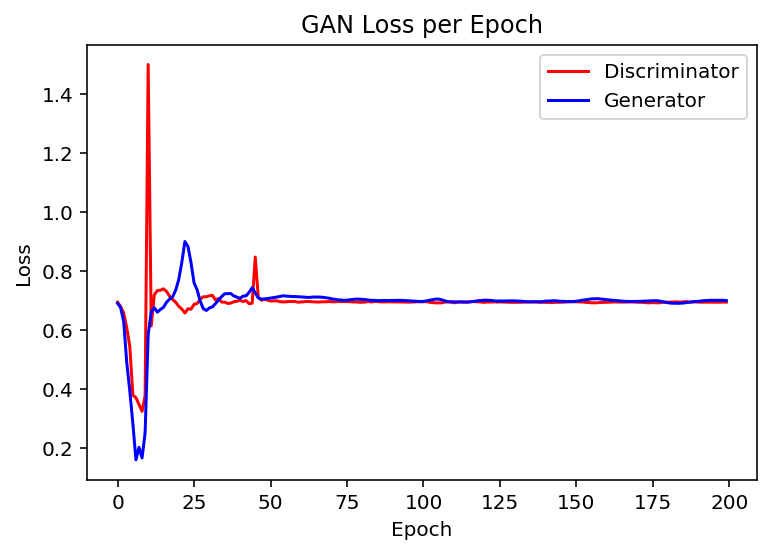

In [121]:
model.plot_loss()

In [122]:
model.save() 
print("model saved")

The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.
model saved
